In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


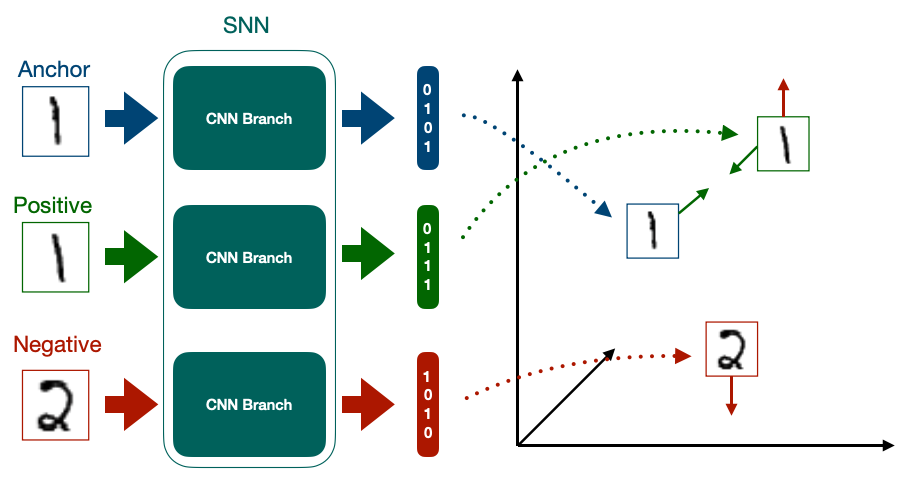

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda"

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
# read the images
row = df.iloc[29]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


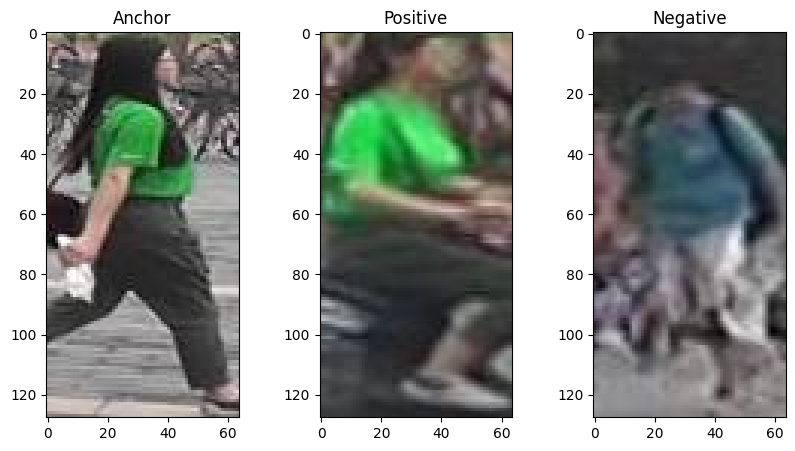

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
ax1.set_title("Anchor")
ax1.imshow(A_img)
ax2.set_title("Positive")
ax2.imshow(P_img)
ax3.set_title("Negative")
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = torch.from_numpy(io.imread(DATA_DIR + row.Anchor)).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(io.imread(DATA_DIR + row.Positive)).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(io.imread(DATA_DIR + row.Negative)).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img



In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print("Train dataset size:", len(trainset))
print("Valid dataset size:", len(validset))

Train dataset size: 3200
Valid dataset size: 800


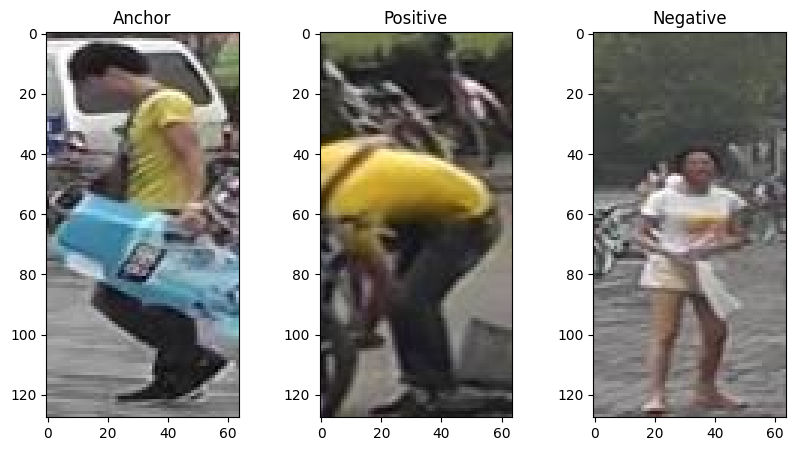

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
print(f"No. of batches in trainloader : {len(train_loader)}")
print(f"No. of batches in validloader : {len(valid_loader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A, P, N in train_loader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [16]:
class APN_Model(nn.Module):
  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [17]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [18]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() # Dropout on
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_emb = model(A)
    P_emb = model(P)
    N_emb = model(N)
    loss = criterion(A_emb, P_emb, N_emb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(dataloader)



In [19]:
def eval_fn(model, dataloader, criterion):
  model.eval() # Dropout off
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_emb = model(A)
      P_emb = model(P)
      N_emb = model(N)
      loss = criterion(A_emb, P_emb, N_emb)

      total_loss += loss.item()

    return total_loss / len(dataloader)



In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [21]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, train_loader, optimizer, criterion)
  valid_loss = eval_fn(model, valid_loader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("Saved weights success")

  print(f"for epoch {i+1} train loss is {train_loss} and valid loss is {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Saved weights success
for epoch 1 train loss is 0.6288553011417389 and valid loss is 0.6211838912963867


100%|██████████| 25/25 [00:02<00:00, 10.36it/s]


Saved weights success
for epoch 2 train loss is 0.3023675386607647 and valid loss is 0.4248006200790405


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Saved weights success
for epoch 3 train loss is 0.23197280645370483 and valid loss is 0.4133909225463867


100%|██████████| 25/25 [00:02<00:00,  8.89it/s]


Saved weights success
for epoch 4 train loss is 0.148798156529665 and valid loss is 0.2217649617791176


100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Saved weights success
for epoch 5 train loss is 0.09300484582781791 and valid loss is 0.17181046009063722


100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


for epoch 6 train loss is 0.0544427390396595 and valid loss is 0.22696660816669464


100%|██████████| 25/25 [00:02<00:00,  8.36it/s]


for epoch 7 train loss is 0.04894185706973076 and valid loss is 0.1912414872646332


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Saved weights success
for epoch 8 train loss is 0.04928787022829056 and valid loss is 0.15238040626049043


100%|██████████| 25/25 [00:02<00:00, 10.76it/s]


Saved weights success
for epoch 9 train loss is 0.04242632269859314 and valid loss is 0.1463982892036438


100%|██████████| 25/25 [00:03<00:00,  8.23it/s]


Saved weights success
for epoch 10 train loss is 0.02545005179941654 and valid loss is 0.13976336240768433


100%|██████████| 25/25 [00:02<00:00, 10.64it/s]


for epoch 11 train loss is 0.04091271474957466 and valid loss is 0.1721566104888916


100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


Saved weights success
for epoch 12 train loss is 0.047186067700386046 and valid loss is 0.1130615484714508


100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


for epoch 13 train loss is 0.028755771964788436 and valid loss is 0.16930463492870332


100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


for epoch 14 train loss is 0.02436736173927784 and valid loss is 0.14655847787857057


100%|██████████| 25/25 [00:02<00:00,  9.70it/s]

for epoch 15 train loss is 0.02698416478931904 and valid loss is 0.2247830933332443


# Get Anchor Embeddings

In [22]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A= torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = pd.DataFrame(np.array(encodings))
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc


In [23]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:45<00:00, 87.83it/s]


In [ ]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

# Inference

In [42]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [57]:
idx = 23
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name
img = torch.from_numpy(io.imread(img_path)).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc=model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()


In [58]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [59]:
distances = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distances = np.append(distances, dist)

In [60]:
print(distances[:3])

[6.8894825  8.02466202 5.91221619]


In [61]:
closest_idx = np.argsort(distances)

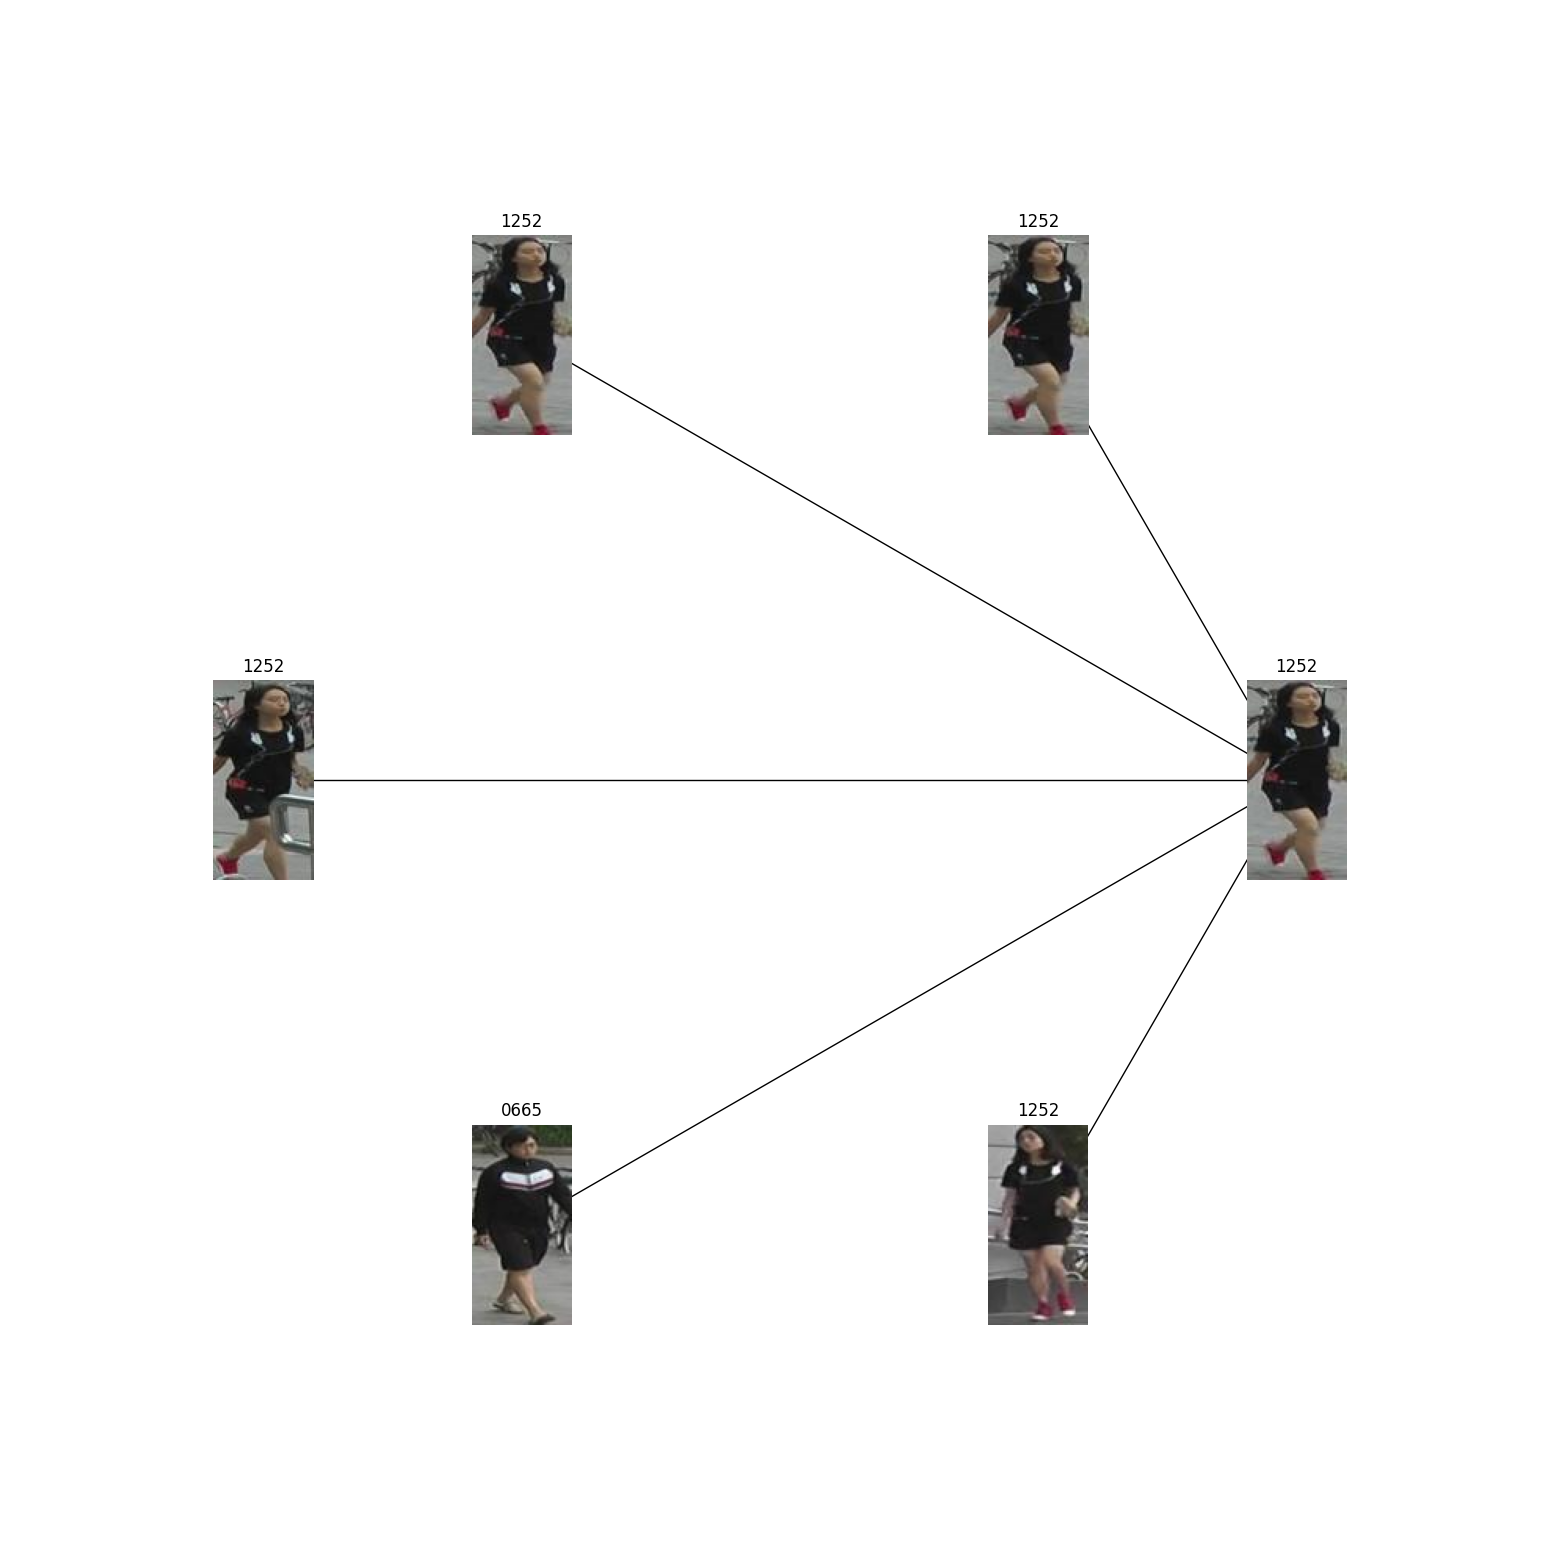

In [62]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distances, no_of_closest = 5);